In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/HiXray.zip"

Streaming output truncated to the last 5000 lines.
  inflating: HiXray - ╕▒▒╛/train/images/005071801012106.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005071901012107.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005072001012108.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005072101012109.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005072901012117.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073001012118.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073301012121.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073601012124.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073601012697.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073801012126.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005073901012700.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005074001012128.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005074101012129.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005074201012130.jpg  
  inflating: HiXray - ╕▒▒╛/train/images/005074201012703.jpg  
  inflating: HiXray

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def parse_annotations(annotation_file_path):
    with open(annotation_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    annotations = []
    for line in lines:
        line = line.strip().split(' ')
        if len(line) == 6:
            image_filename, class_label, xmin, ymin, xmax, ymax = line
            annotations.append({
                'image_filename': image_filename,
                'class_label': class_label,
                'bbox': [int(xmin), int(ymin), int(xmax), int(ymax)]
            })

    return annotations

In [ ]:
annotations_directory = '/content/HiXray - ╕▒▒╛/test/annotations'
images_directory = '/content/HiXray - ╕▒▒╛/test/images'

In [ ]:
all_annotations = []
i = 0
for annotation_filename in os.listdir(annotations_directory):
    if i == 550:
      break
    annotation_file_path = os.path.join(annotations_directory, annotation_filename)
    annotations = parse_annotations(annotation_file_path)
    all_annotations.extend(annotations)
    i += 1

In [ ]:
len(all_annotations)

1230

In [ ]:
all_annotations[0]

{'image_filename': '006641501010216.jpg',
 'class_label': '绿色液体',
 'bbox': [118, 590, 229, 648]}

In [ ]:
images = [cv2.imread(os.path.join(images_directory, annotation['image_filename'])) for annotation in all_annotations]


In [ ]:
len(images)

1230

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32511 (\N{CJK UNIFIED IDEOGRAPH-7EFF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28082 (\N{CJK UNIFIED IDEOGRAPH-6DB2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32511 (\N{CJK UNIFIED IDEOGRAPH-7EFF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

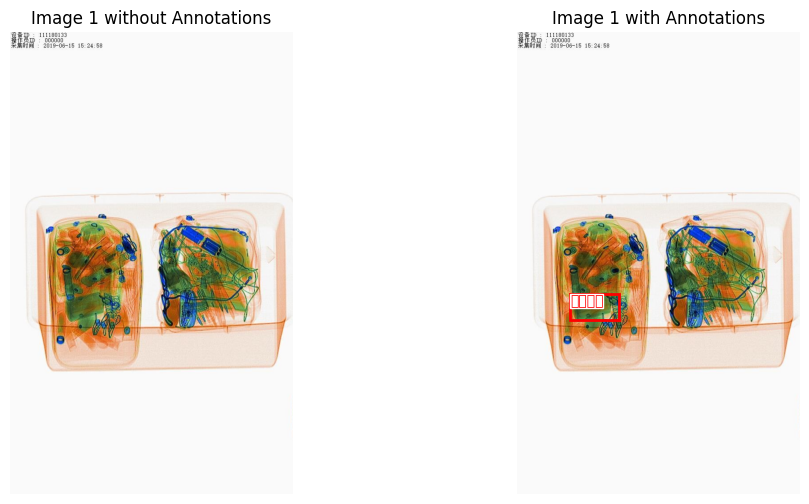

In [ ]:
for i, (image, annotation) in enumerate(zip(images, all_annotations)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title(f"Image {i + 1} without Annotations")

    axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].text(xmin, ymin, annotation['class_label'], color='r', verticalalignment='top', bbox={'color': 'white', 'pad': 0})
    axs[1].axis('off')
    axs[1].set_title(f"Image {i + 1} with Annotations")

    plt.show()
    break

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam


resized_images = [cv2.resize(image, (224, 224)) for image in images]
X = np.array(resized_images) / 255.0

y_boxes = np.array([annotation['bbox'] for annotation in all_annotations])
class_labels = [annotation['class_label'] for annotation in all_annotations]


label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(class_labels)
onehot_encoder = OneHotEncoder(sparse=False)
y_labels_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

X_train, X_temp, y_train_boxes, y_temp_boxes, y_train_labels, y_temp_labels = train_test_split(
    X, y_boxes, y_labels_encoded, test_size=0.2, random_state=42
)

X_val, X_test, y_val_boxes, y_test_boxes, y_val_labels, y_test_labels = train_test_split(
    X_temp, y_temp_boxes, y_temp_labels, test_size=0.5, random_state=42
)

input_shape = (224, 224, 3)
num_classes = len(set(integer_encoded))

bbox_input = Input(shape=(4,), name='bbox_input')
bbox_branch = Dense(128, activation='relu')(bbox_input)

image_input = Input(shape=input_shape, name='image_input')
cnn_branch = Conv2D(64, (3, 3), activation='relu')(image_input)
cnn_branch = MaxPooling2D((2, 2))(cnn_branch)
cnn_branch = Flatten()(cnn_branch)
cnn_branch = Dense(128, activation='relu')(cnn_branch)

combined = Concatenate()([cnn_branch, bbox_branch])
output = Dense(num_classes, activation='softmax', name='class_output')(combined)

model = Model(inputs=[image_input, bbox_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit([X_train, y_train_boxes], y_train_labels, epochs=10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
31/31 [==============================] - 15s 263ms/step - loss: 28.3193 - accuracy: 0.2927
Epoch 2/10
31/31 [==============================] - 6s 193ms/step - loss: 6.2592 - accuracy: 0.3770
Epoch 3/10
31/31 [==============================] - 3s 109ms/step - loss: 3.0346 - accuracy: 0.5152
Epoch 4/10
31/31 [==============================] - 6s 195ms/step - loss: 1.9351 - accuracy: 0.5539
Epoch 5/10
31/31 [==============================] - 5s 163ms/step - loss: 1.9276 - accuracy: 0.6108
Epoch 6/10
31/31 [==============================] - 6s 212ms/step - loss: 1.9456 - accuracy: 0.6484
Epoch 7/10
31/31 [==============================] - 7s 217ms/step - loss: 1.6349 - accuracy: 0.6524
Epoch 8/10
31/31 [==============================] - 7s 223ms/step - loss: 1.4090 - accuracy: 0.6789
Epoch 9/10
31/31 [==============================] - 4s 144ms/step - loss: 1.5066 - accuracy: 0.6829
Epoch 10/10
31/31 [==============================] - 5s 172ms/step - loss: 1.2951 - accuracy: 0.69

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict([X_test, y_test_boxes])
y_pred_labels = np.argmax(y_pred, axis=1)

report = classification_report(np.argmax(y_test_labels, axis=1), y_pred_labels)
print("Classification Report:\n", report)

4/4 [==============================] - 0s 105ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         6
           3       0.56      0.83      0.67        65
           4       0.75      0.75      0.75         8
           5       0.27      0.30      0.29        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2

    accuracy                           0.51       123
   macro avg       0.20      0.24      0.21       123
weighted avg       0.37      0.51      0.42       123



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

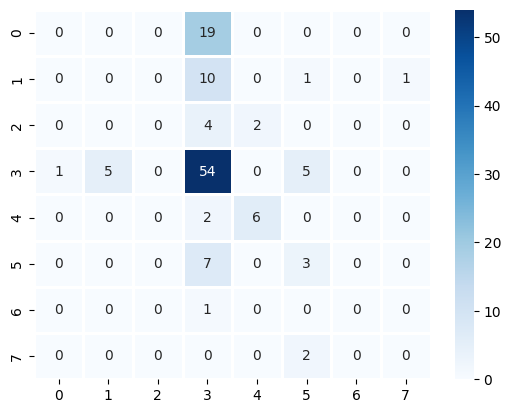

In [ ]:
import sklearn
import seaborn as sns
cf_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_labels)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True)